# Titanic - Machine Learning from Disaster

* Student name: Nicholas Catalano
* Student pace: part time
* Scheduled project review date/time: 20NOV2020 - 3PM EST
* Instructor name: Amber Yandow
* Blog post URL:https://urldefense.com/v3/__https://medium.com/@nickcatalano14__;!!AoaiBx6H!nWUoBo-9m53pD-GWWykqSASeHlDOOpSfGRvCLhZ76_9uc8tkJUBw_6W6GqIjRHzI4q8TGQ$ 

#### Loading python libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

# import pandas for data wrangling
import numpy as np
import pandas as pd
import re, itertools
import matplotlib.pyplot as plt
import seaborn as sns

# import machine learning libraries
import xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


import statistics
from statistics import mode


# from ray import tune

In [2]:
max_evals = 200
criteria_met = 0.02

# Importing data and Baseline Model

In [3]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount = True)

In [4]:
# folder_name = 'data/'
folder_name = r'/content/drive/MyDrive/Colab Notebooks/Kaggle - Titanic Project/data/'

train_data = 'train.csv'
x_test_data = 'test.csv'
y_test_data = 'gender_submission.csv'

df_train = pd.read_csv(folder_name + train_data, index_col = 0)
columns = df_train.columns

df_x_train = df_train[columns[1:]]
y_train = df_train[columns[0]]
y_test = pd.read_csv(folder_name + y_test_data, index_col = 0)

df_x_test = pd.read_csv(folder_name + x_test_data, index_col = 0)

df_x_len = df_x_train.shape[0]

df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Define a function to merge the test and train dataframes.

In [5]:
def train_test_merge(df1, df2):
    merged_df = pd.concat([df1, df2])
    return merged_df

In [6]:
df_master = train_test_merge(df_x_train, df_x_test)

print("Train dataframe entry total: " + str(df_x_train.shape[0]))
print("Test dataframe entry total: " + str(df_x_test.shape[0]))
print("Concatonated dataframe entry total: " + str(df_master.shape[0]))

Train dataframe entry total: 891
Test dataframe entry total: 418
Concatonated dataframe entry total: 1309


In [7]:
df_master.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
df_master.Embarked.isnull().value_counts()

False    1307
True        2
Name: Embarked, dtype: int64

In [9]:
df_master.Fare.isnull().value_counts()

False    1308
True        1
Name: Fare, dtype: int64

In [10]:
def test_train_split(df, columns_drop, columns_one_hot):
    
    df_drop = df.drop(columns_drop, axis = 1)
    onehot_df = df[columns_one_hot]
    onehot_df = pd.get_dummies(onehot_df, columns = columns_one_hot)
    
    onehot_drop_df = df_drop.drop(columns_one_hot, axis = 1)
    df_final = pd.concat([onehot_drop_df, onehot_df], axis = 1)
    
    # Define the X and Y features.
    X_train = df_final.iloc[:df_x_len]
    X_test = df_final.iloc[df_x_len:]    
   
    return X_train, X_test, df_final

In [11]:
def model_baseline():
    
    global train_score, test_score, X_train, X_test, y_train
    
    modelxgb = XGBClassifier(objective = 'binary:logistic', booster = 'gbtree', 
                      eval_metric = 'error', eta = .1,
                      max_depth = 50, colsample_bytree = .4)

    modelxgb.fit(X_train, y_train)

    y_train_pred = modelxgb.predict(X_train)
    y_test_pred = modelxgb.predict(X_test)

    train_score_baseline.append(accuracy_score(y_train, y_train_pred))
    test_score_baseline.append(accuracy_score(y_test, y_test_pred))
    
    #Add feature importance code:
    feature_importance = modelxgb.feature_importances_
    sorted_idx = modelxgb.feature_importances_.argsort()
    
    print("Training set score for xgBoost: %f" % accuracy_score(y_train, y_train_pred))
    print("Testing set score for xgBoost: %f" % accuracy_score(y_test, y_test_pred))
    
    print("")
    fig, ax = plt.subplots(figsize=(16,8))
    plt.barh(X_train.columns[sorted_idx], modelxgb.feature_importances_[sorted_idx])
    plt.xlabel("Xgboost Feature Importance")

    return y_test, y_test_pred

### Initial model without feature engineering

In [12]:
train_score_baseline, test_score_baseline, train_score, test_score = [], [], [], []

Training set score for xgBoost: 0.942761
Testing set score for xgBoost: 0.866029



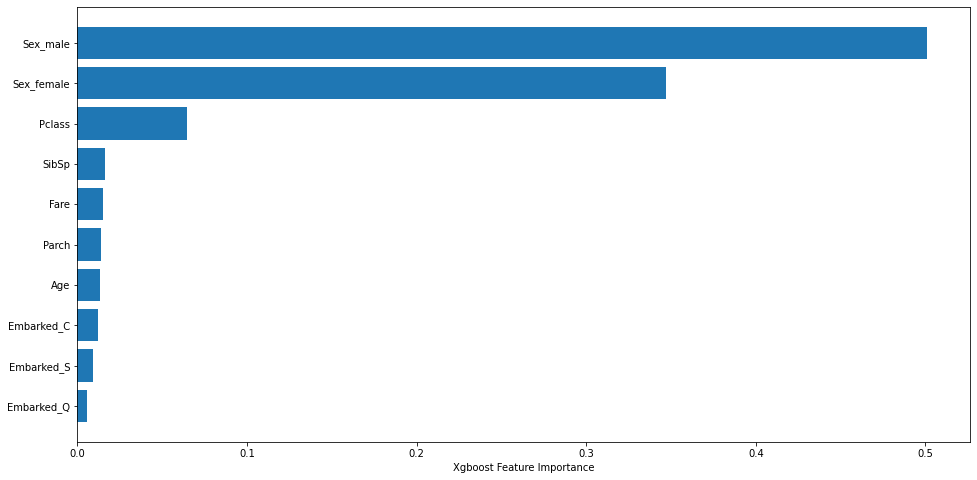

In [13]:
columns_drop = ['Name', 'Ticket', 'Cabin']
columns_one_hot = ['Sex','Embarked']

X_train, X_test, df_final = test_train_split(df_master, columns_drop, columns_one_hot)

y_test, y_test_pred = model_baseline()

In [14]:
print(classification_report(y_test.to_numpy(), y_test_pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90       266
           1       0.82      0.80      0.81       152

    accuracy                           0.87       418
   macro avg       0.86      0.85      0.85       418
weighted avg       0.87      0.87      0.87       418



## Bayesian Optimization with HYPEROPT

First, we must definte the universe of tuning parameters to iterate through:

In [15]:
space={'eta' : hp.quniform('eta', 0, .2, 0.001),
       'gamma': hp.uniform ('gamma', 0, 1),
       'max_depth': hp.quniform("max_depth", 5, 7, 1),
       'min_child_weight' : hp.quniform('min_child_weight', 1, 2, 1),
       'colsample_bytree' : hp.quniform('colsample_bytree', 0.9, 1, 0.05),
       'reg_alpha' : hp.quniform('reg_alpha', 0, 5, 1),
       'reg_lambda' : hp.uniform('reg_lambda', 1, 1.15),
        'n_estimators': hp.quniform("n_estimators", 10, 150, 10),
        'seed': 0
    }

In [16]:
def bayesian_opt(space):
    
    global train_score, test_score, saved_space, saved_space_high_acc, criteria_met
   
    modelxgb = xgb.XGBClassifier(
        objective = 'binary:logistic', 
        booster = 'gbtree',
        eval_metric = ["error"],
        colsample_bytree = space['colsample_bytree'], 
        eta = int(space['eta']), 
        gamma = space['gamma'], 
        max_depth = int(space['max_depth']), 
        min_child_weight = space['min_child_weight'], 
        n_estimators = int(space['n_estimators']), 
        reg_alpha = int(space['reg_alpha']), 
        reg_lambda = space['reg_lambda'])
       
    modelxgb.fit(X_train, y_train)
    
    y_train_pred = modelxgb.predict(X_train)
    y_test_pred = modelxgb.predict(X_test)

    accuracy_train  = accuracy_score(y_train, y_train_pred)
    accuracy_test  = accuracy_score(y_test, y_test_pred)
    
    train_score.append(accuracy_train)
    test_score.append(accuracy_test)
    
    accuracy = abs(accuracy_train - accuracy_test)
    
    saved_space.append(space)

    if accuracy < criteria_met and accuracy_train > 0.8:
        saved_space_high_acc.append(space)
        test_high_accur.append(accuracy_test)
        train_high_accur.append(accuracy_train)
    
    
    # print ("SCORE:", accuracy)
    return {'loss': accuracy, 'status': STATUS_OK }

In [17]:
def clear_parameters():
  global saved_space, saved_space_high_acc, test_high_accur, train_high_accur, best_hyperparams, test_score, train_score

  saved_space = []
  saved_space_high_acc = []
  test_score = []
  train_score = []
  test_high_accur = []
  train_high_accur = []
  y_test_pred = []
  best_hyperparams = {}

clear_parameters()

trials = Trials()

best_hyperparams = fmin(fn = bayesian_opt,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = max_evals,

                        trials = trials)

100%|██████████| 200/200 [00:22<00:00,  8.78it/s, best loss: 0.0003248862897985427]


In [18]:
def plot_train_test(train_score, test_score):
    
    # plot lines
    fig, ax = plt.subplots(figsize=(16,8))

    x = list(range(len(test_score)))

    plt.plot(x, train_score, label = "Training Set Score")
    plt.plot(x, test_score, label = "Test Set Score")
    plt.legend(loc = 'best')

    plt.axhline(y = 0.90, color='g', linestyle='--', lw=2)
    
    ax.set_xlabel('Model Iteration')
    ax.set_ylabel('Score for xgBoost')
    plt.legend()
    plt.show()

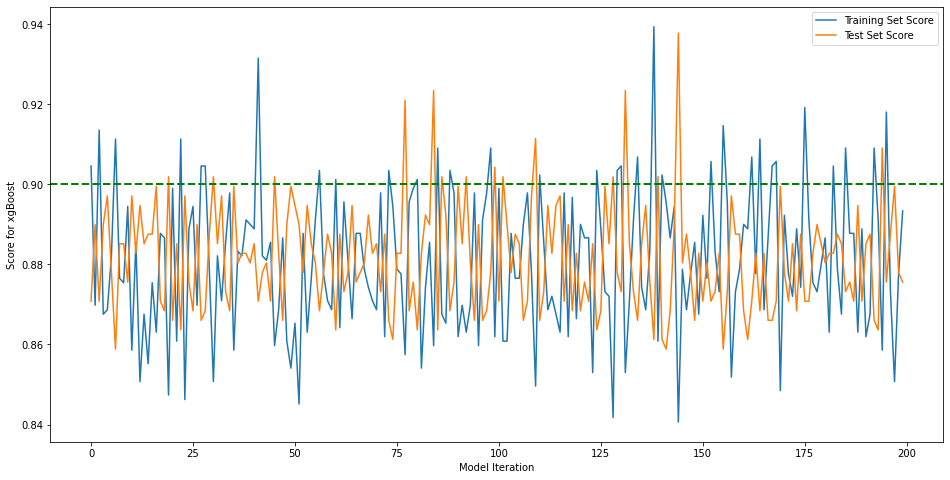

In [19]:
plot_train_test(train_score, test_score)

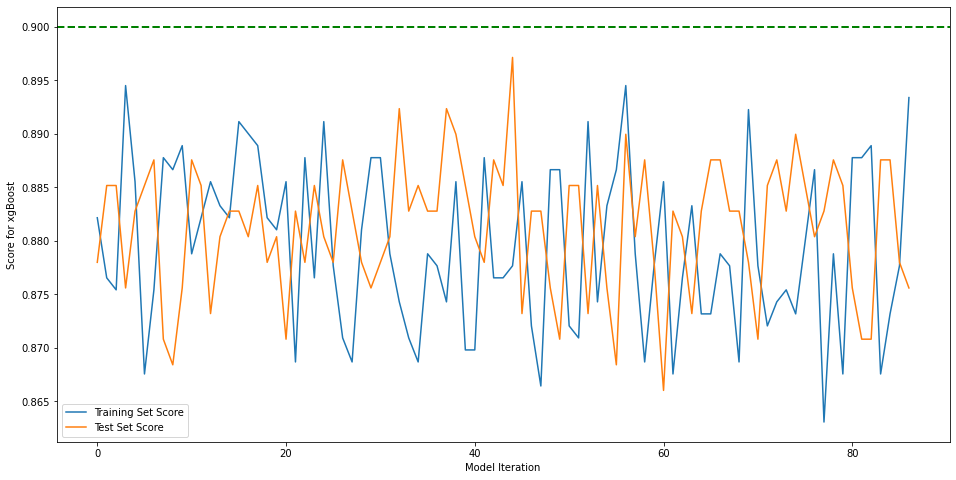

In [20]:
if bool(train_high_accur):
  plot_train_test(train_high_accur, test_high_accur)

In [21]:
def best_hyp():

  global train_high_accur, train_score, test_score, best_hyperparams, saved_space_high_acc, saved_space

  #empty list
  sub_list = []

  #two lists are passed to zip 
  zip_object = zip(train_score, test_score)

  #loop to find diff of each element
  for list1_i, list2_i in zip_object:
      sub_list.append(abs(list1_i - list2_i))  
  
  if bool(train_high_accur):
    best_hyperparams = saved_space_high_acc[train_high_accur.index(max(train_high_accur))]
  else:
    best_hyperparams = saved_space[sub_list.index(min(sub_list))]

## Tuned Model

In [22]:
def model_tuned():
    
    global train_score_tuned, test_score_tuned, X_train, X_test, y_train, y_test, best_hyperparams
    
    # Build input matrices for XGBoost
    train_set = xgb.DMatrix(X_train, label=y_train)
    test_set = xgb.DMatrix(X_test, label=y_test)
      
    modelxgb = XGBClassifier(objective = 'binary:logistic', booster = 'gbtree', 
                      eval_metric = 'error',
                             colsample_bytree = best_hyperparams['colsample_bytree'], 
                             eta = int(best_hyperparams['eta']), 
                             gamma = best_hyperparams['gamma'], 
                             max_depth = int(best_hyperparams['max_depth']), 
                             min_child_weight = best_hyperparams['min_child_weight'], 
                             n_estimators = int(best_hyperparams['n_estimators']),
                             reg_alpha = int(best_hyperparams['reg_alpha']), 
                             reg_lambda = best_hyperparams['reg_lambda'])

    modelxgb.fit(X_train, y_train)

    y_train_pred = modelxgb.predict(X_train)
    y_test_pred = modelxgb.predict(X_test)

    train_score_tuned.append(accuracy_score(y_train, y_train_pred))
    test_score_tuned.append(accuracy_score(y_test, y_test_pred))
    
    print("Training set score for xgBoost: %f" % accuracy_score(y_train, y_train_pred))
    print("Testing set score for xgBoost: %f" % accuracy_score(y_test, y_test_pred))

    print("")

    #Add feature importance code:
    feature_importance = modelxgb.feature_importances_
    sorted_idx = modelxgb.feature_importances_.argsort()

    fig, ax = plt.subplots(figsize=(16,8))
    plt.barh(X_train.columns[sorted_idx], modelxgb.feature_importances_[sorted_idx])
    plt.xlabel("Xgboost Feature Importance")

    return y_test, y_test_pred

Training set score for xgBoost: 0.894501
Testing set score for xgBoost: 0.875598



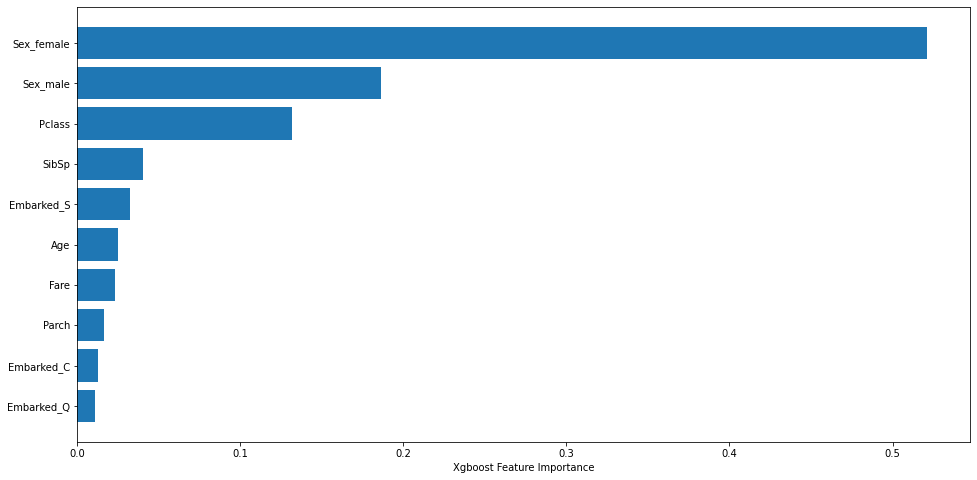

In [23]:
best_hyp()

train_score_tuned = []
test_score_tuned = []
 
y_test, y_test_pred = model_tuned()

In [24]:
print(classification_report(y_test.to_numpy(), y_test_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91       266
           1       0.87      0.78      0.82       152

    accuracy                           0.88       418
   macro avg       0.87      0.85      0.86       418
weighted avg       0.88      0.88      0.87       418



In [25]:
def model_performance_trend():

    global train_score_baseline, test_score_baseline, train_score_tuned, test_score_tuned
    
    fig, ax = plt.subplots(figsize=(16,8))

    x = list(range(len(train_score_tuned)))

    plt.plot(x, train_score_baseline, c = 'b', label = "Train Baseline")
    plt.plot(x, test_score_baseline, c = 'r', label = "Test Baseline")

    plt.plot(x, train_score_tuned, c = 'b', linestyle=':',label = "Train Tuned")
    plt.plot(x, test_score_tuned, c = 'r', linestyle=':', label = "Test Tuned")

    ax.set_xlabel('Model Iteration')
    ax.set_ylabel('Score for xgBoost')
    plt.legend()
    plt.show()
    plt.show()

## 1. EDTA - NULL's

In [26]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    1309 non-null   int64  
 1   Name      1309 non-null   object 
 2   Sex       1309 non-null   object 
 3   Age       1046 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   Ticket    1309 non-null   object 
 7   Fare      1308 non-null   float64
 8   Cabin     295 non-null    object 
 9   Embarked  1307 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 112.5+ KB


##### There are too many Null values in the 'Cabin' column, this column will be removed from the dataset as the level of importance is extremely low.

In [27]:
df_master = df_master.drop(['Cabin'], axis = 1)

## EDTA - Fare and Embarked [Handling Null Values]

In [28]:
filter_by_null = (df_master.Fare.isnull())
df_master[filter_by_null]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,
1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S


In [29]:
filter_by = (df_master.Sex == 'male') & (df_master.Pclass == 3) & (df_master.SibSp == 0) & (df_master.Parch == 0)


df_master.Fare= df_master.Fare.fillna(df_master[filter_by].Fare.mean())

In [30]:
df_master[df_master.index == 1044]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,
1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,9.249918,S


In [31]:
filter_by_null = df_master.Embarked.isnull()
df_master[filter_by_null]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,
62,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN
830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN


In [32]:
filter_by = (df_master.Pclass == 1) & (df_master.Sex == 'female')

most_frequent = mode(list(df_master[filter_by].Embarked))

df_master.Embarked = df_master.Embarked.fillna(most_frequent)

In [33]:
df_master[(df_master.index == 62) | (df_master.index == 830)]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,
62,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,C
830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,C


### EDTA - Age [Handling Null Values]

* First we will create new features to support EDTA analysis.

### Name:
* Creating a column for the rank/status of an individual on board

In [34]:
df_master['name_title'] = df_master.Name.apply(lambda x:x.split(',')[1].split('.')[0].strip())
df_master.replace({'Ms':'Miss'}, inplace = True)
df_master['name_title'].value_counts()

Mr              757
Miss            262
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
the Countess      1
Don               1
Jonkheer          1
Lady              1
Mme               1
Dona              1
Sir               1
Capt              1
Name: name_title, dtype: int64

In [35]:
df_master['first_name'] = df_master.Name.apply(lambda x:x.split('.')[1].strip())
df_master['last_name'] = df_master.Name.apply(lambda x:x.split(',')[0].strip())

In [36]:
df_master[df_master.Age.isnull()].groupby(['name_title','Pclass']).count()

Name  Sex  Age  SibSp  ...  Fare  Embarked  first_name  last_name
name_title Pclass                         ...                                       
Dr         1          1    1    0      1  ...     1         1           1          1
Master     3          8    8    0      8  ...     8         8           8          8
Miss       1          1    1    0      1  ...     1         1           1          1
           2          2    2    0      2  ...     2         2           2          2
           3         48   48    0     48  ...    48        48          48         48
Mr         1         27   27    0     27  ...    27        27          27         27
           2         13   13    0     13  ...    13        13          13         13
           3        136  136    0    136  ...   136       136         136        136
Mrs        1         10   10    0     10  ...    10        10          10         10
           2          1    1    0      1  ...     1         1           1          1
           3         16   16    0     16  ...    16        16          16         16

[11 rows x 10 columns]

### 1. Filling in the 'Nan' for the 'Dr' name_title:

In [37]:
filter_by = (df_master.name_title == 'Dr')
df_master[filter_by] = df_master[filter_by].fillna(df_master[filter_by].Age.mean())

### 2. Master

In [38]:
filter_by = (df_master.name_title == 'Master') & (df_master.Pclass == 3)
df_master[filter_by] = df_master[filter_by].fillna(df_master[filter_by].Age.mean())

### 3. Miss

#### Pclass = 1, 2, 3 [Solo Pasangers]

In [39]:
for p_class in list(set(df_master.Pclass)):
    
    filter_by = (df_master.name_title == 'Miss') & (df_master.Pclass == p_class) & (df_master.SibSp == 0) & (df_master.Parch == 0)

    df_master[filter_by] = df_master[filter_by].fillna(df_master[filter_by].Age.mean())

#### Pclass = 3

In [40]:
filter_by = (df_master.name_title == 'Miss') & (df_master.Pclass == 3) & (df_master.SibSp == 1) & (df_master.Parch == 1)
df_master[filter_by] = df_master[filter_by].fillna(df_master[filter_by].Age.mean())

In [41]:
filter_by = (df_master.name_title == 'Miss') & (df_master.Pclass == 3) & (df_master.SibSp == 1) & (df_master.Parch == 0)
df_master[filter_by] = df_master[filter_by].fillna(df_master[filter_by].Age.mean())

In [42]:
filter_by = (df_master.name_title == 'Miss') & (df_master.Pclass == 3) & (df_master.SibSp > 1)
df_master[filter_by] = df_master[filter_by].fillna(df_master[filter_by].Age.mean())

In [43]:
filter_by = (df_master.name_title == 'Miss') & (df_master.Pclass == 3) & (df_master.Parch == 2)
df_master[filter_by] = df_master[filter_by].fillna(df_master[filter_by].Age.mean())

### 3. Mr

#### Pclass = 1, 2, 3 [Solo Pasangers]

In [44]:
for p_class in list(set(df_master.Pclass)):
    
    filter_by = (df_master.name_title == 'Mr') & (df_master.Pclass == p_class) & (df_master.SibSp == 0) & (df_master.Parch == 0)

    df_master[filter_by] = df_master[filter_by].fillna(df_master[filter_by].Age.mean())

#### Pclass = 3 additional missing Age data

In [45]:
filter_by = (df_master.name_title == 'Mr') & (df_master.Pclass == 3) & (df_master.SibSp == 1) & (df_master.Parch == 0)
df_master[filter_by] = df_master[filter_by].fillna(df_master[filter_by].Age.mean())

In [46]:
filter_by = (df_master.name_title == 'Mr') & (df_master.Pclass == 3) & (df_master.SibSp > 1)
df_master[filter_by] = df_master[filter_by].fillna(df_master[filter_by].Age.mean())

In [47]:
filter_by = (df_master.name_title == 'Mr') & (df_master.Pclass == 3) & (df_master.Parch > 1)
df_master[filter_by] = df_master[filter_by].fillna(df_master[filter_by].Age.mean())

### 3. Mrs

#### Pclass = 1, 2, 3 [Married Women without children]

In [48]:
for p_class in list(set(df_master.Pclass)):
    
    filter_by = (df_master.name_title == 'Mrs') & (df_master.Pclass == p_class) & (df_master.Parch == 0)

    df_master[filter_by] = df_master[filter_by].fillna(df_master[filter_by].Age.mean())

#### Pclass = 1, 2, 3 [Married Women with children]

In [49]:
for p_class in list(set(df_master.Pclass)):
    
    filter_by = (df_master.name_title == 'Mrs') & (df_master.Pclass == p_class) & (df_master.Parch > 0)

    df_master[filter_by] = df_master[filter_by].fillna(df_master[filter_by].Age.mean())

In [50]:
df_master.Age.isnull().value_counts()

False    1309
Name: Age, dtype: int64

In [51]:
df_master.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,name_title,first_name,last_name
PassengerId,,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr,Owen Harris,Braund
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs,John Bradley (Florence Briggs Thayer),Cumings
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,Laina,Heikkinen
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs,Jacques Heath (Lily May Peel),Futrelle
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr,William Henry,Allen


In [52]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      1309 non-null   int64  
 1   Name        1309 non-null   object 
 2   Sex         1309 non-null   object 
 3   Age         1309 non-null   float64
 4   SibSp       1309 non-null   int64  
 5   Parch       1309 non-null   int64  
 6   Ticket      1309 non-null   object 
 7   Fare        1309 non-null   float64
 8   Embarked    1309 non-null   object 
 9   name_title  1309 non-null   object 
 10  first_name  1309 non-null   object 
 11  last_name   1309 non-null   object 
dtypes: float64(2), int64(3), object(7)
memory usage: 132.9+ KB


Training set score for xgBoost: 0.943883
Testing set score for xgBoost: 0.854067



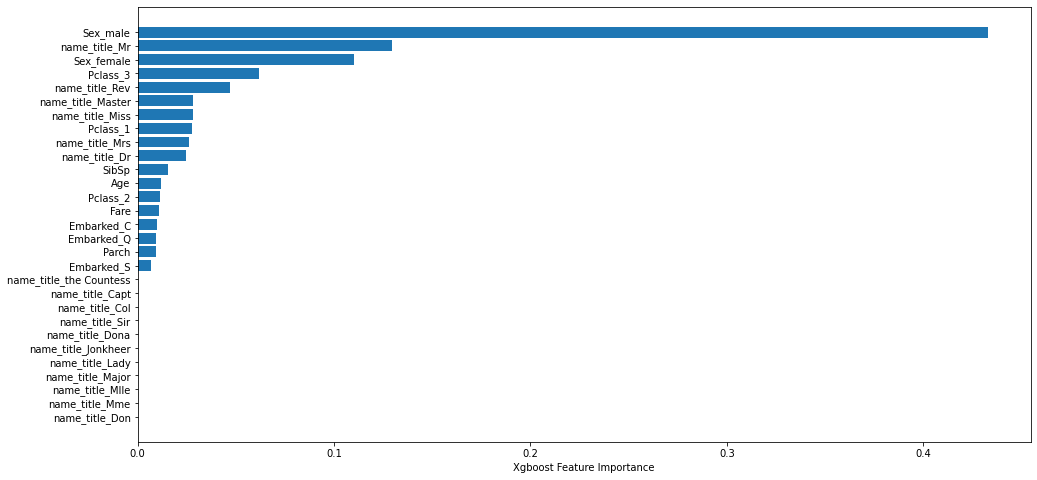

In [53]:
columns_drop = ['Name', 'Ticket','first_name','last_name']
columns_one_hot = ['Pclass','Sex','Embarked','name_title']

X_train, X_test, df_final = test_train_split(df_master, columns_drop, columns_one_hot)

y_test, y_test_pred = model_baseline()

In [54]:
print(classification_report(y_test.to_numpy(), y_test_pred))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88       266
           1       0.79      0.81      0.80       152

    accuracy                           0.85       418
   macro avg       0.84      0.84      0.84       418
weighted avg       0.85      0.85      0.85       418



In [55]:
clear_parameters()

In [56]:
trials = Trials()

best_hyperparams = fmin(fn = bayesian_opt,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = max_evals,
                        trials = trials)

100%|██████████| 200/200 [00:37<00:00,  5.39it/s, best loss: 0.00020674582078084036]


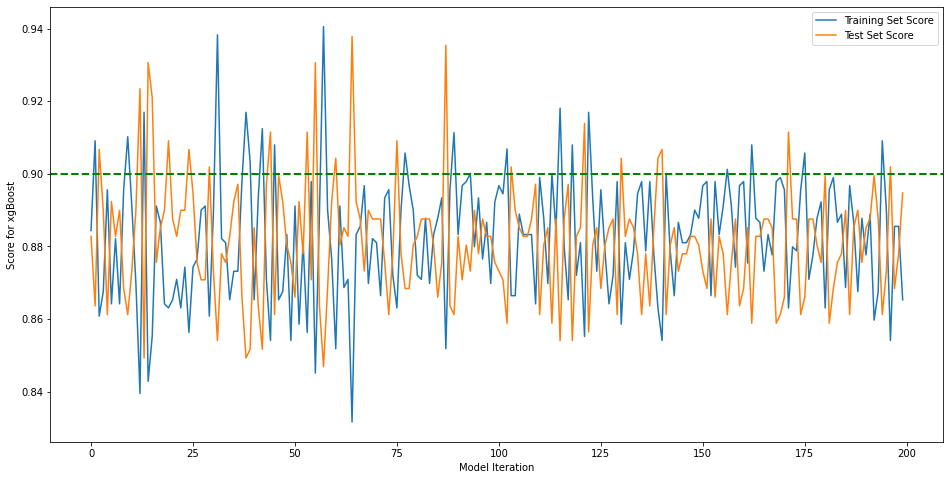

In [57]:
plot_train_test(train_score, test_score)

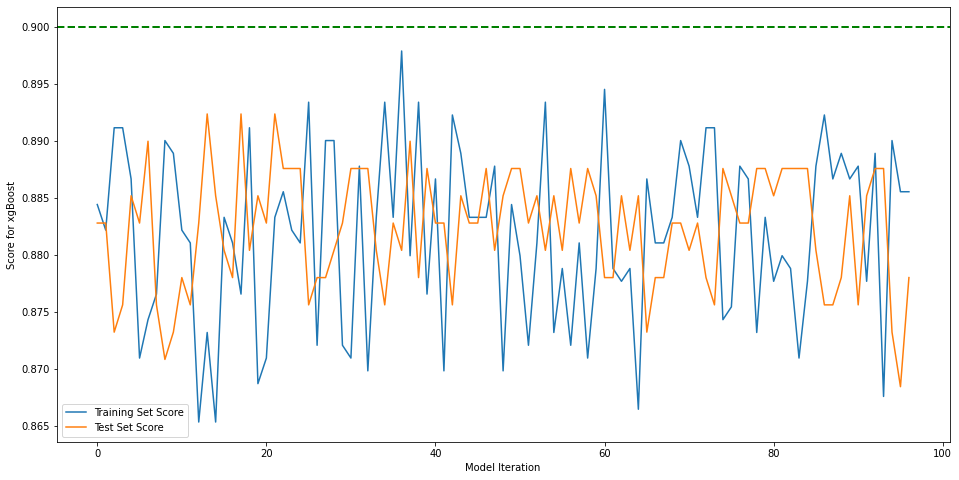

In [58]:
if bool(train_high_accur):
  plot_train_test(train_high_accur, test_high_accur)

Training set score for xgBoost: 0.897868
Testing set score for xgBoost: 0.880383



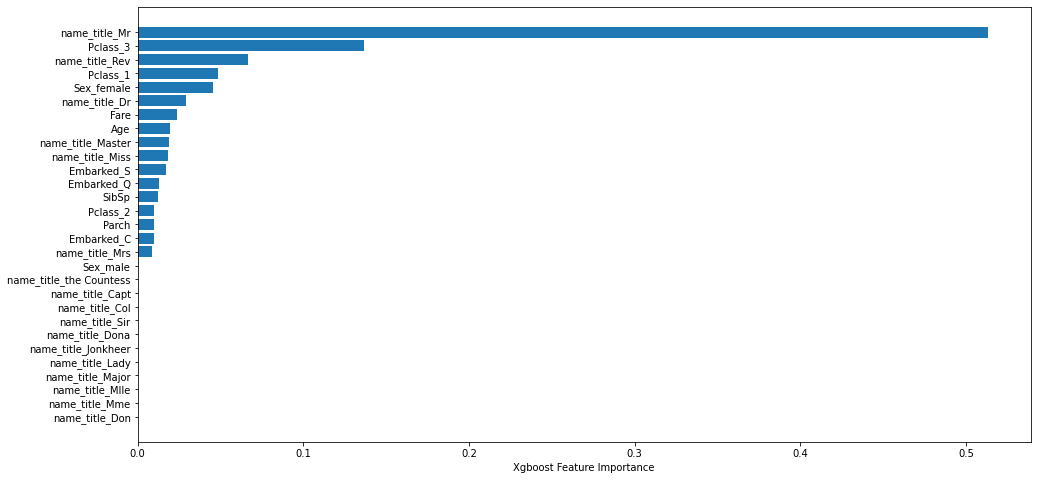

In [59]:
best_hyp()

y_test, y_test_pred = model_tuned()

In [60]:
print(classification_report(y_test.to_numpy(), y_test_pred))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       266
           1       0.84      0.82      0.83       152

    accuracy                           0.88       418
   macro avg       0.87      0.87      0.87       418
weighted avg       0.88      0.88      0.88       418



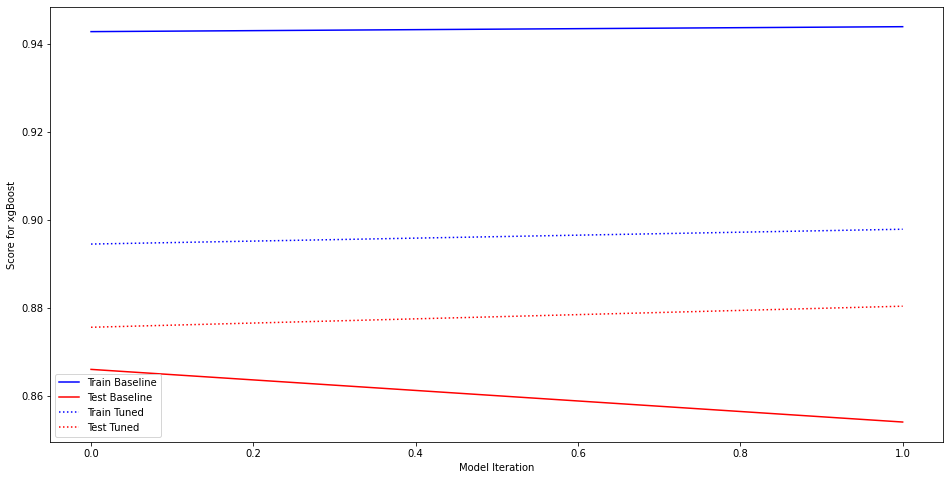

In [61]:
model_performance_trend()

# 2. Using 'Age' to categorize a passanger age into bins: 

In [62]:
df_master['age_range'] = np.nan

age_bins = [(0, 20, 1), (20, 25, 2), (25, 30, 3), (30, 40, 4), (40, 100, 5)]

for ages in age_bins:
    filter_by = (df_master.Age >= ages[0]) & (df_master.Age < ages[1])
    
    df_master[filter_by] = df_master[filter_by].fillna(ages[2])

Training set score for xgBoost: 0.928171
Testing set score for xgBoost: 0.863636



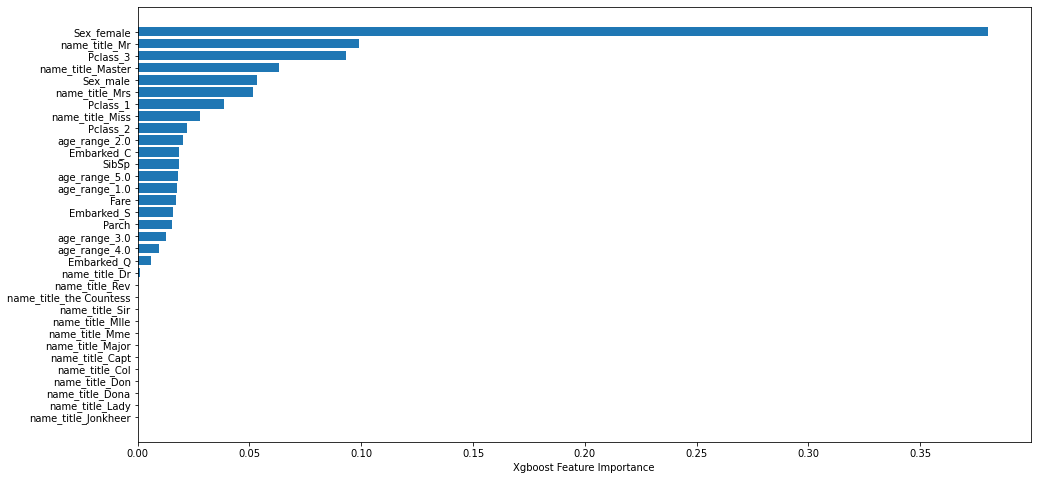

In [63]:
columns_drop = ['Name', 'Ticket','first_name','last_name', 'Age']
columns_one_hot = ['Pclass','Sex','Embarked','name_title', 'age_range']

X_train, X_test, df_final = test_train_split(df_master, columns_drop, columns_one_hot)

y_test, y_test_pred = model_baseline()

In [64]:
print(classification_report(y_test.to_numpy(), y_test_pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       266
           1       0.82      0.80      0.81       152

    accuracy                           0.86       418
   macro avg       0.85      0.85      0.85       418
weighted avg       0.86      0.86      0.86       418



In [65]:
clear_parameters()

trials = Trials()

best_hyperparams = fmin(fn = bayesian_opt,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = max_evals,
                        trials = trials)

100%|██████████| 200/200 [00:34<00:00,  5.78it/s, best loss: 5.907023450879567e-05]


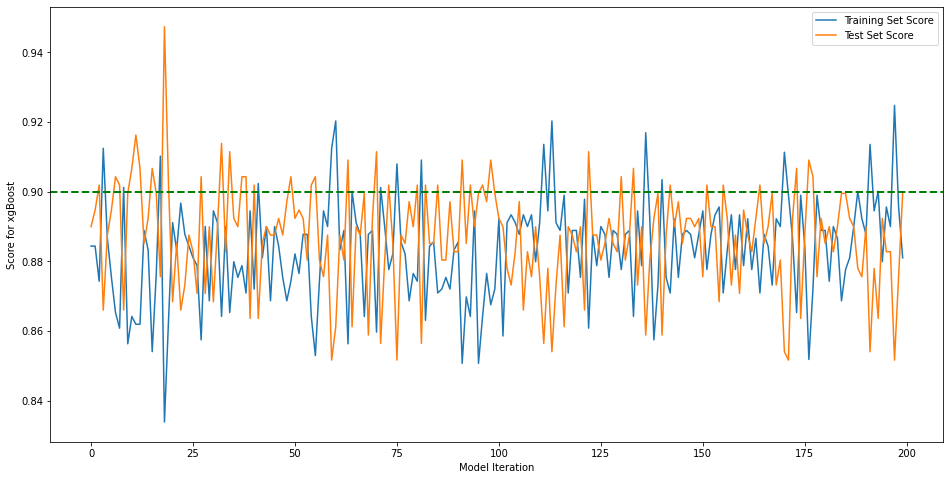

In [66]:
plot_train_test(train_score, test_score)

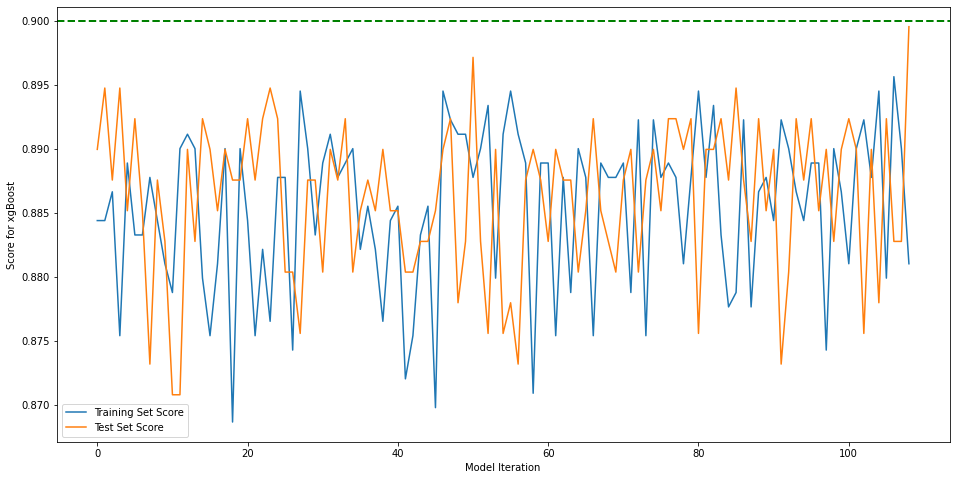

In [67]:
if bool(train_high_accur):
  plot_train_test(train_high_accur, test_high_accur)

Training set score for xgBoost: 0.895623
Testing set score for xgBoost: 0.882775



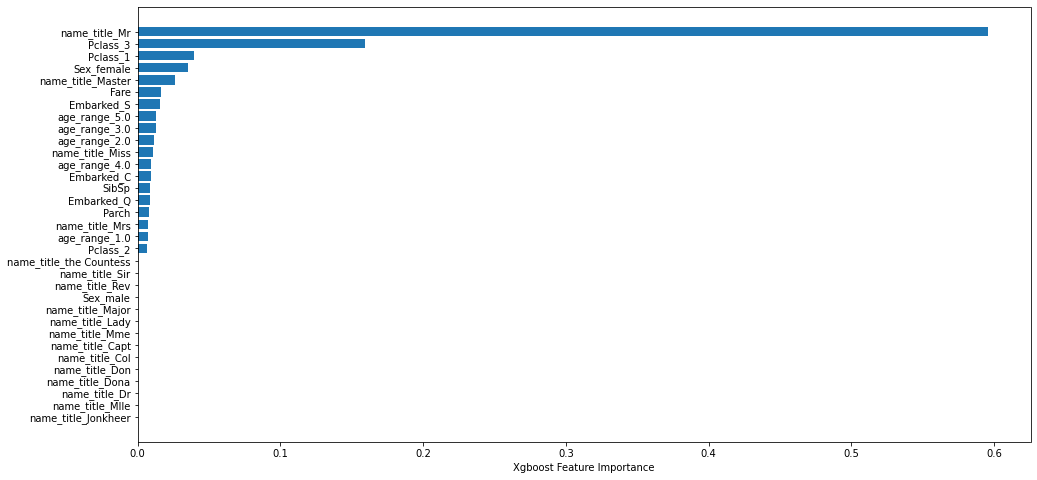

In [68]:
best_hyp()

y_test, y_test_pred = model_tuned()

In [69]:
print(classification_report(y_test.to_numpy(), y_test_pred))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       266
           1       0.84      0.84      0.84       152

    accuracy                           0.88       418
   macro avg       0.87      0.87      0.87       418
weighted avg       0.88      0.88      0.88       418



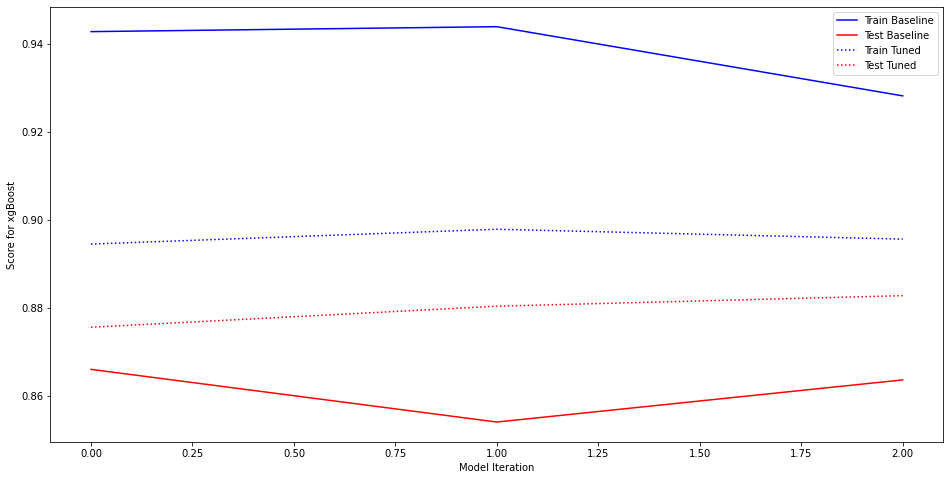

In [70]:
model_performance_trend()

# Feature engineering with 'Title: 

In [71]:
title_list = df_master['name_title'].value_counts().index.tolist()

common_titles = ["Mr", "Miss","Mrs", "Dr", "Master", "Rev"]

for i in common_titles:
    title_list.remove(i)
    
for passanger in list(df_master.index):
    if df_master.loc[passanger,'name_title'] in title_list:
        df_master.at[passanger,'name_title'] = "unique"

Training set score for xgBoost: 0.925926
Testing set score for xgBoost: 0.858852



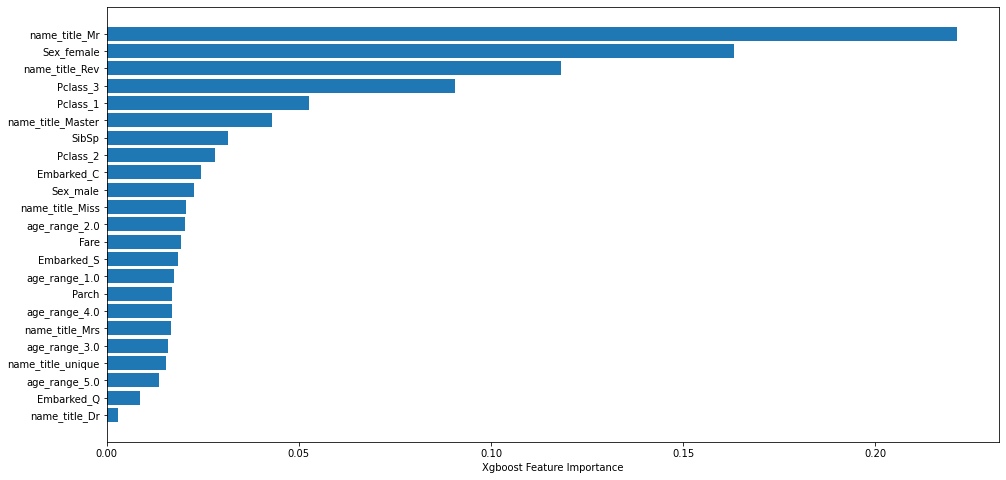

In [72]:
columns_drop = ['Name', 'Ticket','first_name','last_name', 'Age']
columns_one_hot = ['Pclass','Sex','Embarked','name_title', 'age_range']

X_train, X_test, df_final = test_train_split(df_master, columns_drop, columns_one_hot)

y_test, y_test_pred = model_baseline()

In [73]:
print(classification_report(y_test.to_numpy(), y_test_pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       266
           1       0.81      0.80      0.81       152

    accuracy                           0.86       418
   macro avg       0.85      0.85      0.85       418
weighted avg       0.86      0.86      0.86       418



In [74]:
clear_parameters()

best_hyperparams = {}

trials = Trials()

best_hyperparams = fmin(fn = bayesian_opt,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = max_evals,
                        trials = trials)

100%|██████████| 200/200 [00:28<00:00,  6.95it/s, best loss: 0.0003544214070529961]


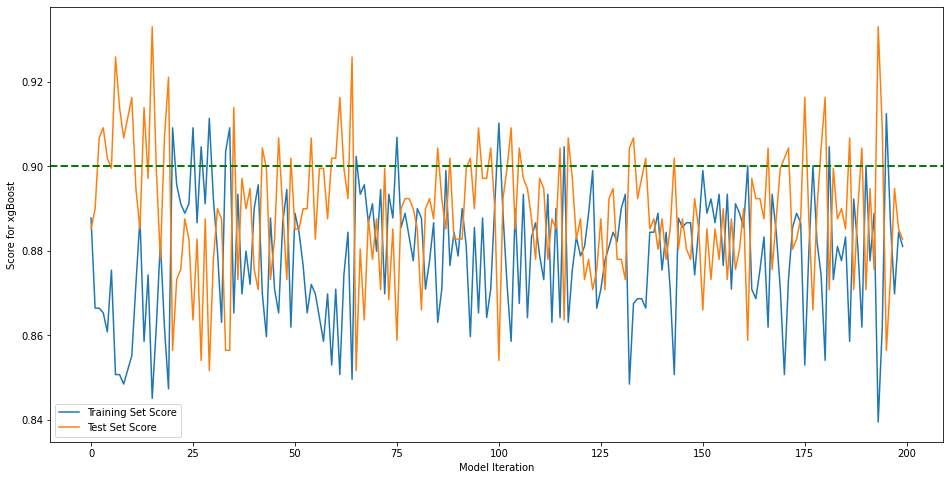

In [75]:
plot_train_test(train_score, test_score)

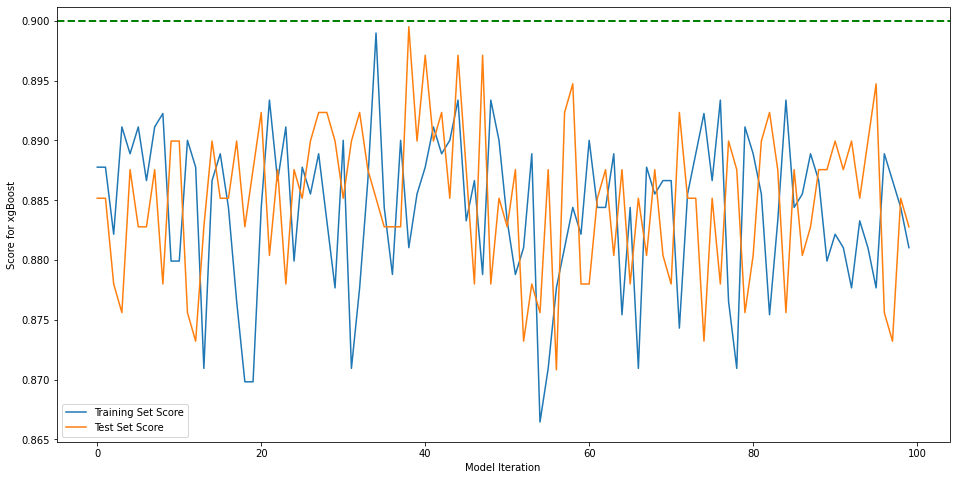

In [76]:
if bool(train_high_accur):
  plot_train_test(train_high_accur, test_high_accur)

Training set score for xgBoost: 0.898990
Testing set score for xgBoost: 0.885167



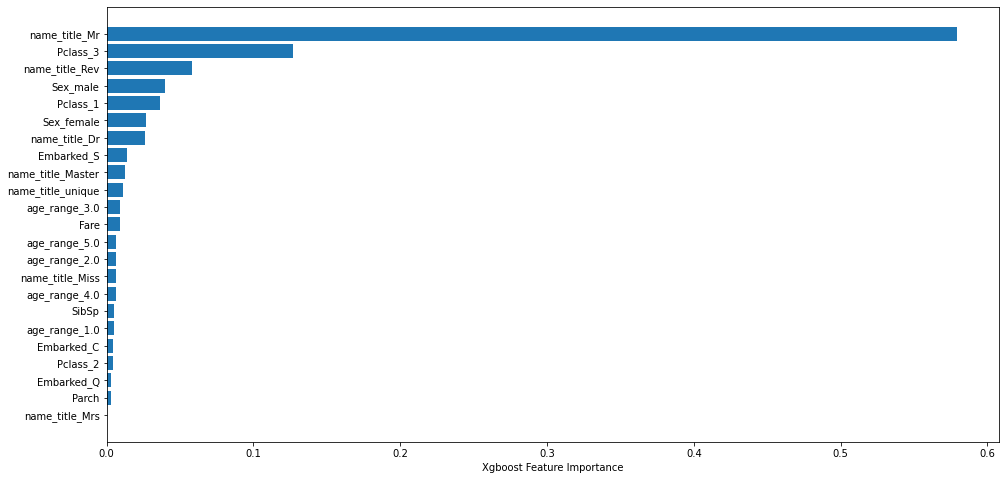

In [77]:
best_hyp()

y_test, y_test_pred = model_tuned()

In [78]:
print(classification_report(y_test.to_numpy(), y_test_pred))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       266
           1       0.84      0.85      0.84       152

    accuracy                           0.89       418
   macro avg       0.88      0.88      0.88       418
weighted avg       0.89      0.89      0.89       418



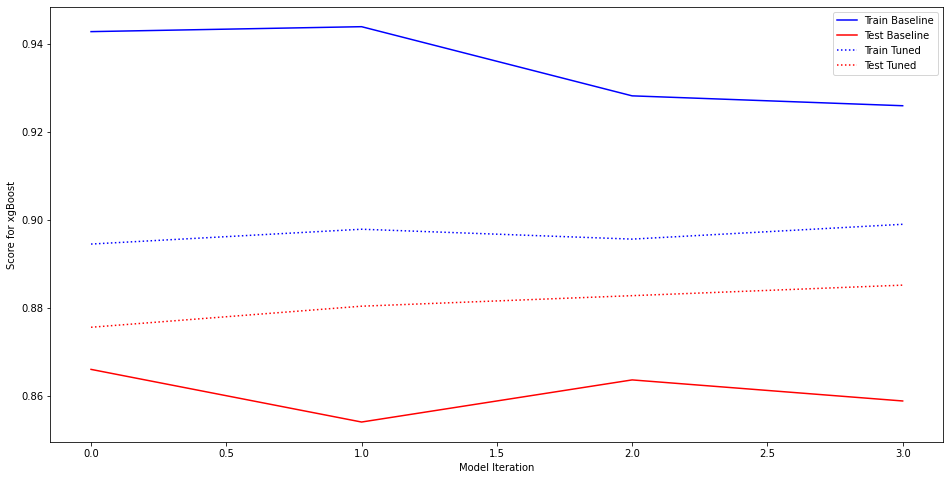

In [79]:
model_performance_trend()

# Ticket value per person

In [80]:
ticket_group_size = {}

for ticket in list(set((df_master['Ticket']))):
    ticket_group_size[ticket] = float(len(list(df_master[(df_master['Ticket'] == ticket)].index)))

df_master['ticket_group_size'] = df_master['Ticket'].map(ticket_group_size)

In [81]:
df_master['cost_per_person'] = df_master.Fare / df_master.ticket_group_size

In [82]:
df_master.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,name_title,first_name,last_name,age_range,ticket_group_size,cost_per_person
PassengerId,,,,,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr,Owen Harris,Braund,2.0,1.0,7.25000
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs,John Bradley (Florence Briggs Thayer),Cumings,4.0,2.0,35.64165
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,Laina,Heikkinen,3.0,1.0,7.92500
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs,Jacques Heath (Lily May Peel),Futrelle,4.0,2.0,26.55000
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr,William Henry,Allen,4.0,1.0,8.05000


Training set score for xgBoost: 0.933782
Testing set score for xgBoost: 0.858852



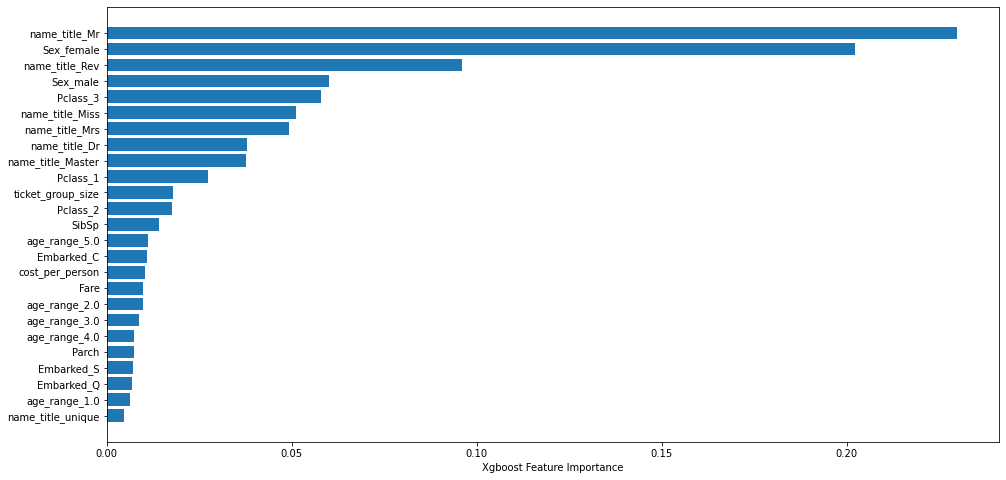

In [83]:
columns_drop = ['Name', 'Ticket','first_name','last_name', 'Age']
columns_one_hot = ['Pclass','Sex','Embarked','name_title', 'age_range']

X_train, X_test, df_final = test_train_split(df_master, columns_drop, columns_one_hot)

y_test, y_test_pred = model_baseline()

In [84]:
print(classification_report(y_test.to_numpy(), y_test_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       266
           1       0.82      0.79      0.80       152

    accuracy                           0.86       418
   macro avg       0.85      0.84      0.85       418
weighted avg       0.86      0.86      0.86       418



In [85]:
clear_parameters()

trials = Trials()

best_hyperparams = fmin(fn = bayesian_opt,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = max_evals,
                        trials = trials)

100%|██████████| 200/200 [00:34<00:00,  5.78it/s, best loss: 5.907023450879567e-05]


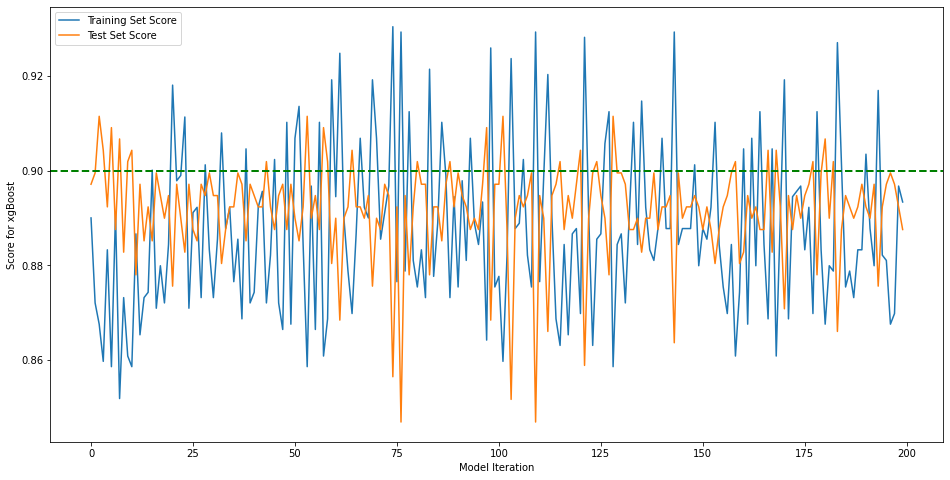

In [86]:
plot_train_test(train_score, test_score)

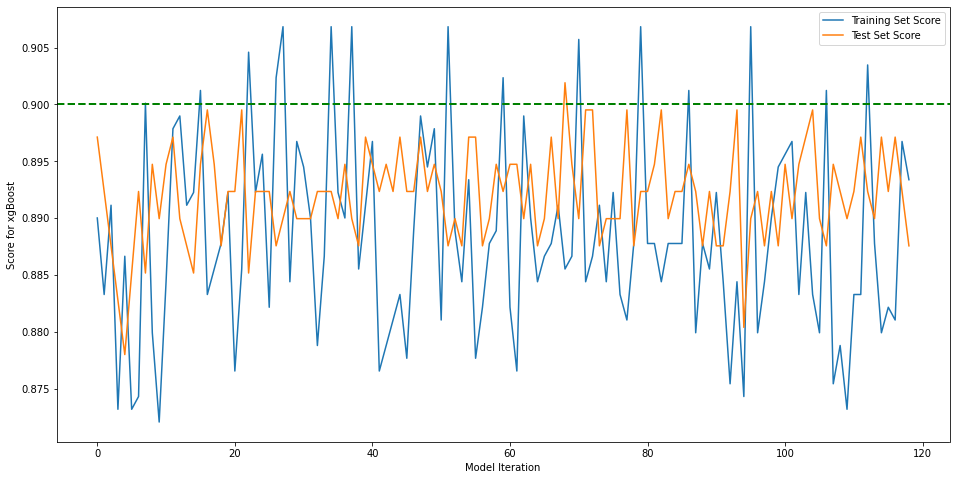

In [87]:
if bool(train_high_accur):
  plot_train_test(train_high_accur, test_high_accur)

Training set score for xgBoost: 0.906846
Testing set score for xgBoost: 0.889952



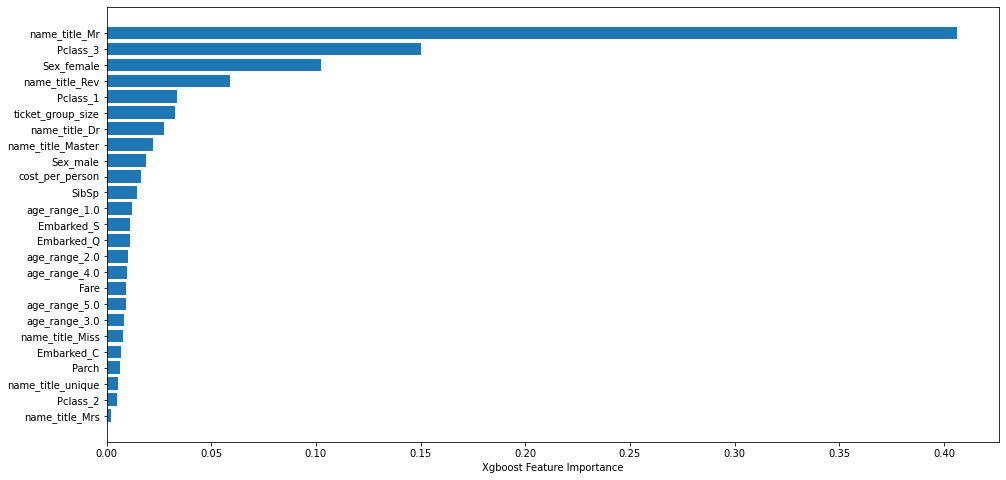

In [88]:
best_hyp()

y_test, y_test_pred = model_tuned()

In [89]:
print(classification_report(y_test.to_numpy(), y_test_pred))

              precision    recall  f1-score   support

           0       0.92      0.91      0.91       266
           1       0.84      0.86      0.85       152

    accuracy                           0.89       418
   macro avg       0.88      0.88      0.88       418
weighted avg       0.89      0.89      0.89       418



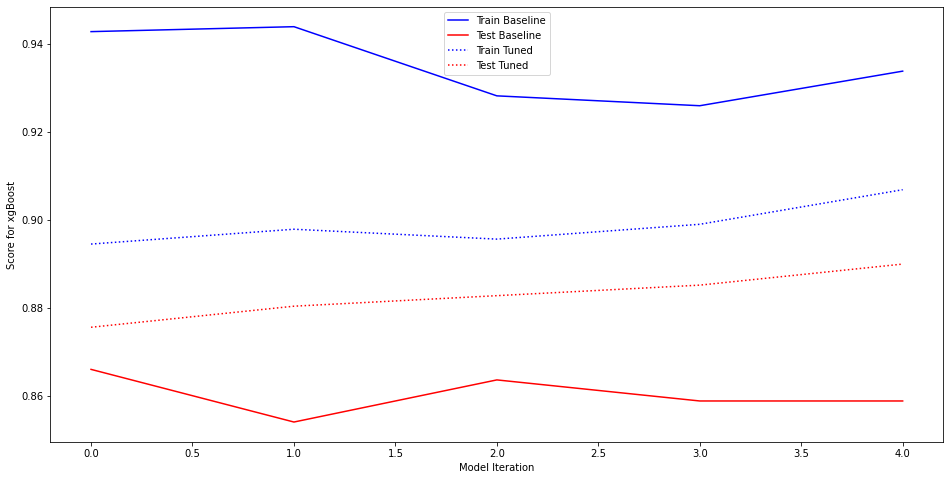

In [90]:
model_performance_trend()

# Family size

In [91]:
df_master['family_size'] = (df_master.SibSp + df_master.Parch + 1)

Training set score for xgBoost: 0.936027
Testing set score for xgBoost: 0.861244



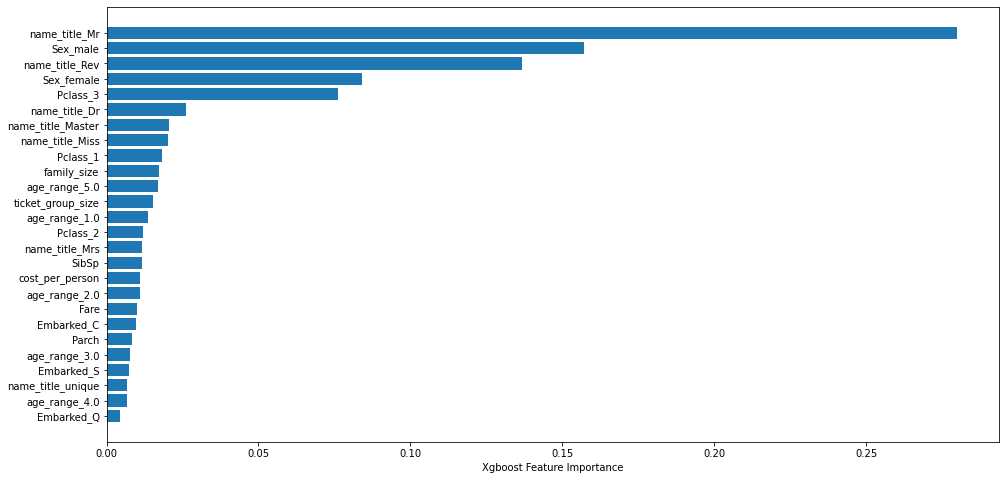

In [92]:
columns_drop = ['Name', 'Ticket','first_name','last_name', 'Age']
columns_one_hot = ['Pclass','Sex','Embarked','name_title', 'age_range']

X_train, X_test, df_final = test_train_split(df_master, columns_drop, columns_one_hot)

y_test, y_test_pred = model_baseline()

In [93]:
print(classification_report(y_test.to_numpy(), y_test_pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       266
           1       0.81      0.80      0.81       152

    accuracy                           0.86       418
   macro avg       0.85      0.85      0.85       418
weighted avg       0.86      0.86      0.86       418



In [94]:
clear_parameters()

trials = Trials()

best_hyperparams = fmin(fn = bayesian_opt,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = max_evals,
                        trials = trials)

100%|██████████| 200/200 [00:29<00:00,  6.78it/s, best loss: 5.907023450879567e-05]


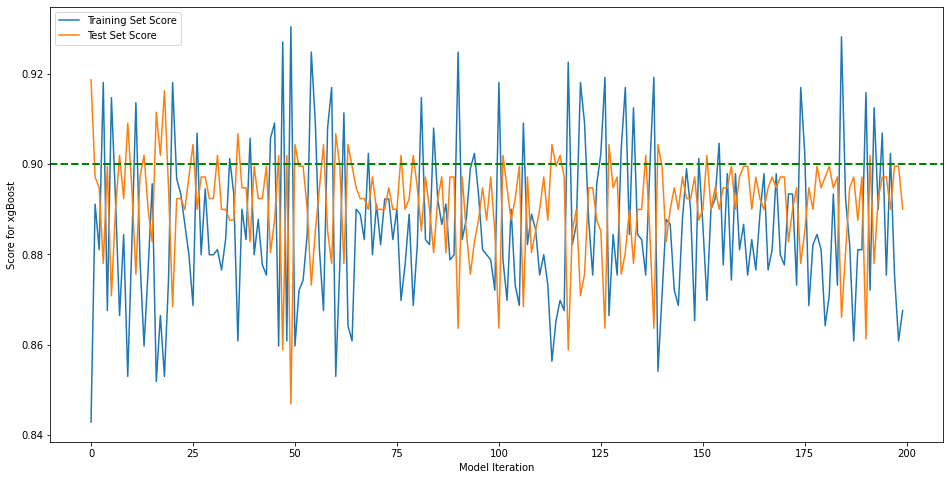

In [95]:
plot_train_test(train_score, test_score)

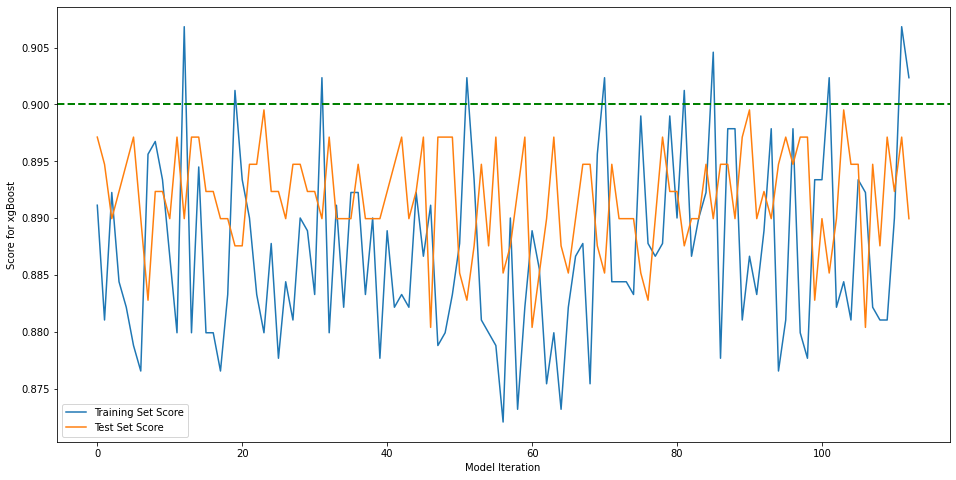

In [96]:
if bool(train_high_accur):
  plot_train_test(train_high_accur, test_high_accur)

Training set score for xgBoost: 0.906846
Testing set score for xgBoost: 0.889952



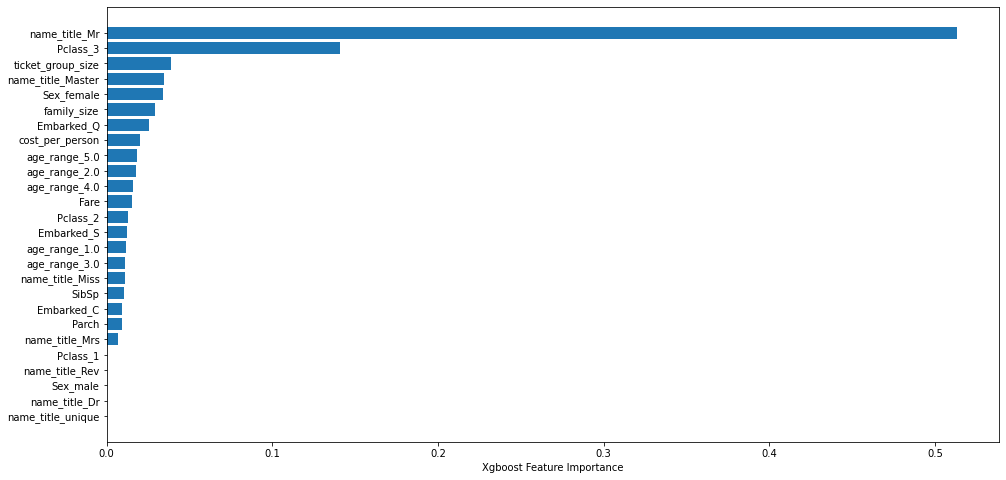

In [97]:
best_hyp()

y_test, y_test_pred = model_tuned()

In [98]:
print(classification_report(y_test.to_numpy(), y_test_pred))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       266
           1       0.84      0.87      0.85       152

    accuracy                           0.89       418
   macro avg       0.88      0.89      0.88       418
weighted avg       0.89      0.89      0.89       418



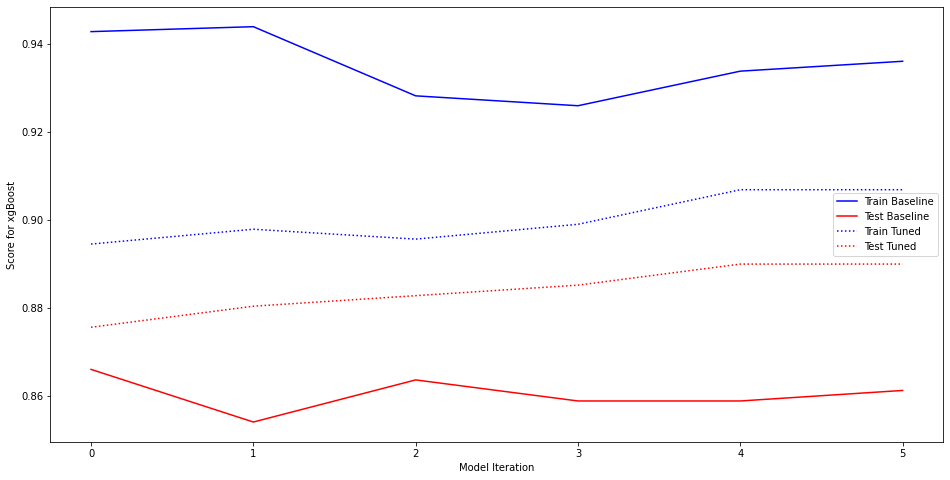

In [99]:
model_performance_trend()

## Create new categories for family size.  
1. Solo pasangers
2. Married Couples
3. Small Family [3 - 4]
4. Medium Family [5 - 6]
5. Large Family [6+]

In [100]:
family_map ={
    1: 'Single',
    2: 'Couples',
    3: 'Small',
    4: 'Small',
    5: 'Medium',
    6: 'Medium',
    7: 'Large',
    8: 'Large',
    11: 'Large'
    
}

df_master['family_cat'] = df_master['family_size'].map(family_map)

Training set score for xgBoost: 0.959596
Testing set score for xgBoost: 0.842105



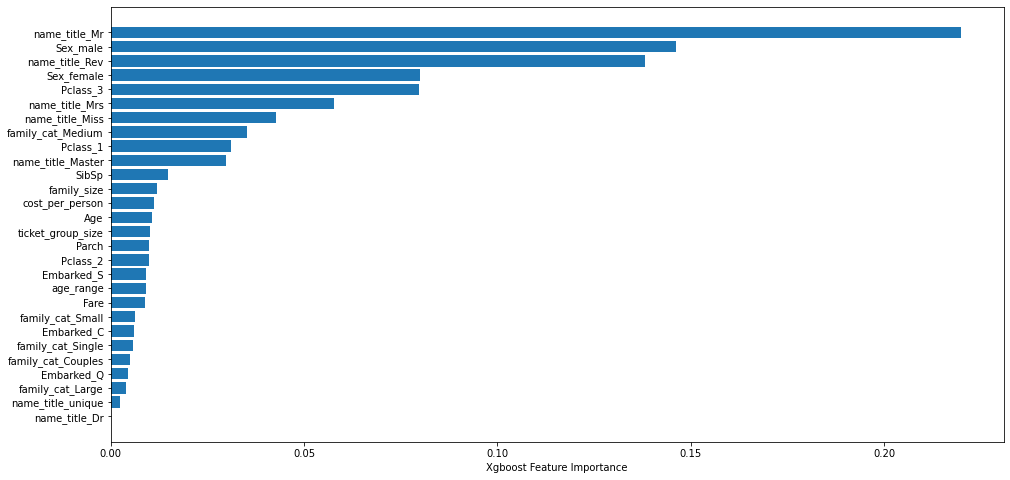

In [101]:
columns_drop = ['Name', 'Ticket','first_name','last_name']
columns_one_hot = ['Pclass','Sex','Embarked','name_title', 'family_cat']

X_train, X_test, df_final = test_train_split(df_master, columns_drop, columns_one_hot)

y_test, y_test_pred = model_baseline()

In [102]:
print(classification_report(y_test.to_numpy(), y_test_pred))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87       266
           1       0.77      0.81      0.79       152

    accuracy                           0.84       418
   macro avg       0.83      0.84      0.83       418
weighted avg       0.84      0.84      0.84       418



In [103]:
clear_parameters()

trials = Trials()

best_hyperparams = fmin(fn = bayesian_opt,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = max_evals,
                        trials = trials)

100%|██████████| 200/200 [00:36<00:00,  5.54it/s, best loss: 2.9535117254342325e-05]


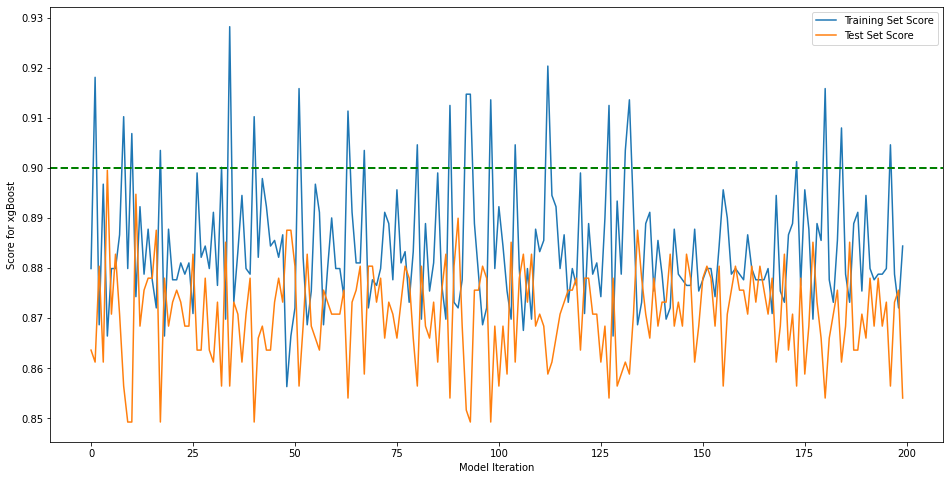

In [104]:
plot_train_test(train_score, test_score)

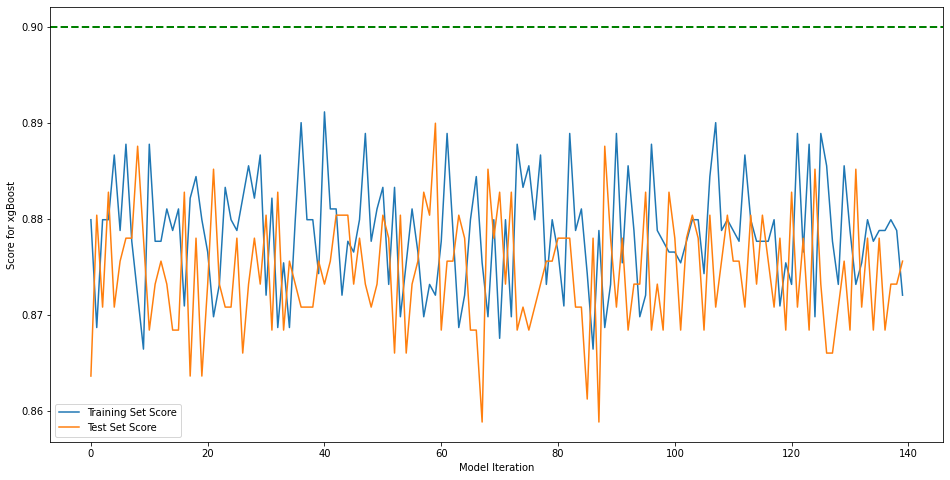

In [105]:
if bool(train_high_accur):
  plot_train_test(train_high_accur, test_high_accur)

Training set score for xgBoost: 0.891134
Testing set score for xgBoost: 0.873206



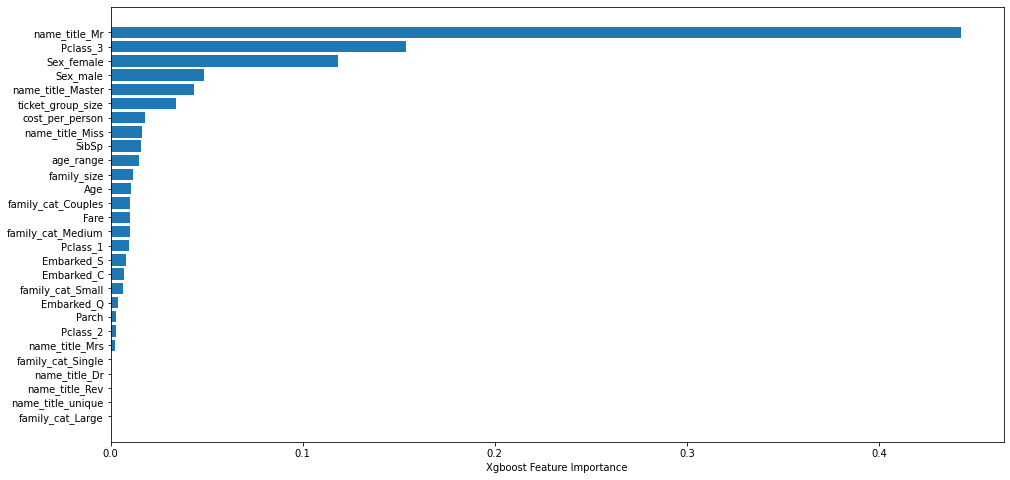

In [106]:
best_hyp()

y_test, y_test_pred = model_tuned()

In [107]:
print(classification_report(y_test.to_numpy(), y_test_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       266
           1       0.82      0.83      0.83       152

    accuracy                           0.87       418
   macro avg       0.86      0.86      0.86       418
weighted avg       0.87      0.87      0.87       418



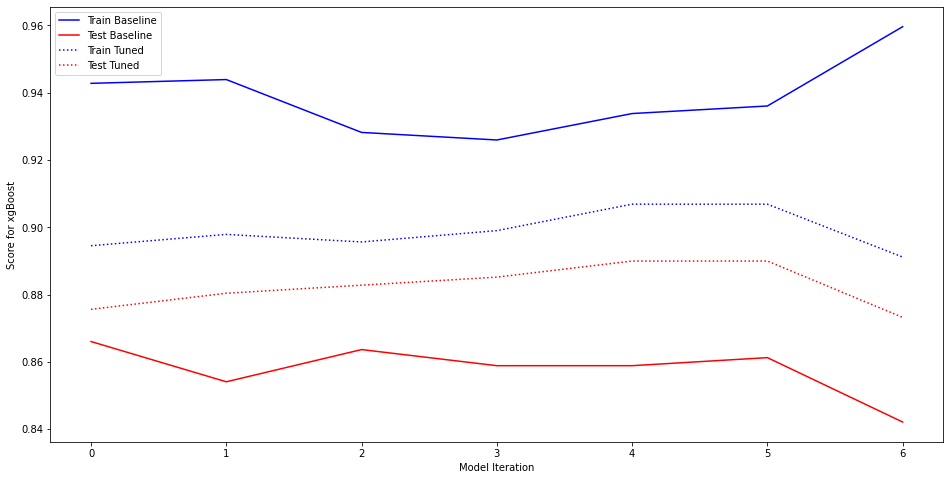

In [108]:
model_performance_trend()

## Create new categories for how many females/males in a family.

In [109]:
df_master['males_in_family'] = 0
df_master['females_in_family'] = 0

In [110]:
for p_class, gender in zip(list(set(df_master.Pclass)) * 2, ['male', 'female'] * len(set(df_master.Pclass))):
    
    filter_by_1 = (df_master.Pclass == p_class) & (df_master.family_size > 2)
       
    for family in list(set(df_master[filter_by_1].last_name)):
        filter_by_2 = filter_by_1 & (df_master.last_name == family)
        
        count = len(df_master[filter_by_2 & (df_master.Sex == gender)])
        
        for i in list(df_master[filter_by_2].index):
            
            df_master.at[i, gender + 's_in_family'] = count

Training set score for xgBoost: 0.937149
Testing set score for xgBoost: 0.861244



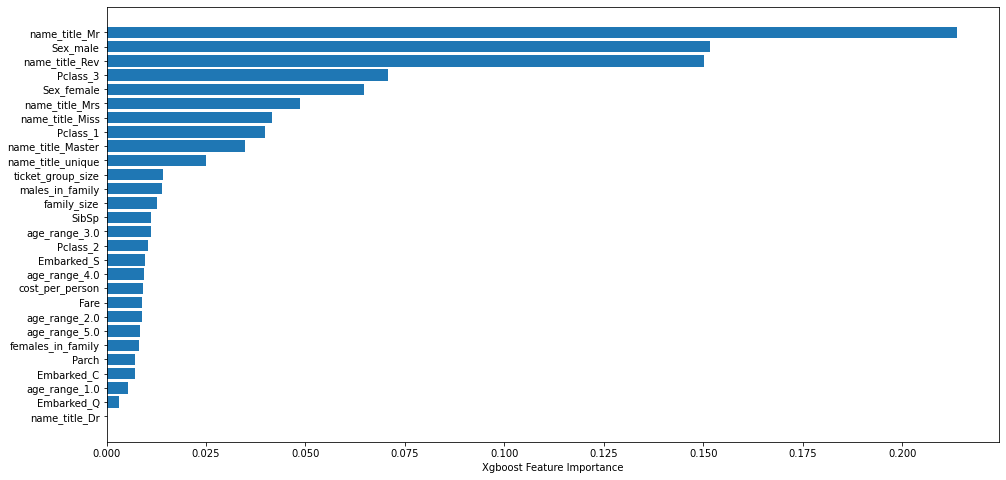

In [111]:
columns_drop = ['Name', 'Ticket','first_name','last_name', 'family_cat', 'Age']
columns_one_hot = ['Pclass','Sex','Embarked','name_title', 'age_range']

X_train, X_test, df_final = test_train_split(df_master, columns_drop, columns_one_hot)

y_test, y_test_pred = model_baseline()

In [112]:
print(classification_report(y_test.to_numpy(), y_test_pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       266
           1       0.81      0.81      0.81       152

    accuracy                           0.86       418
   macro avg       0.85      0.85      0.85       418
weighted avg       0.86      0.86      0.86       418



In [113]:
clear_parameters()

trials = Trials()

best_hyperparams = fmin(fn = bayesian_opt,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = max_evals,
                        trials = trials)

100%|██████████| 200/200 [00:38<00:00,  5.17it/s, best loss: 0.00020674582078084036]


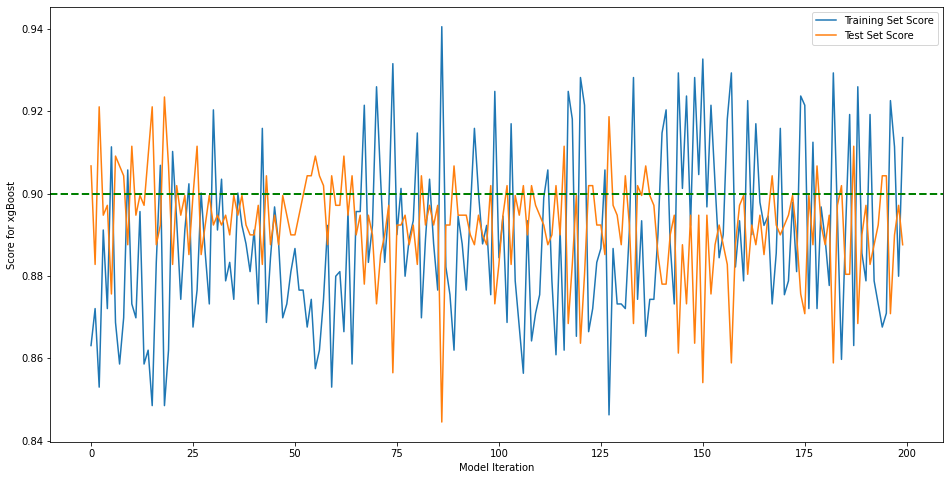

In [114]:
plot_train_test(train_score, test_score)

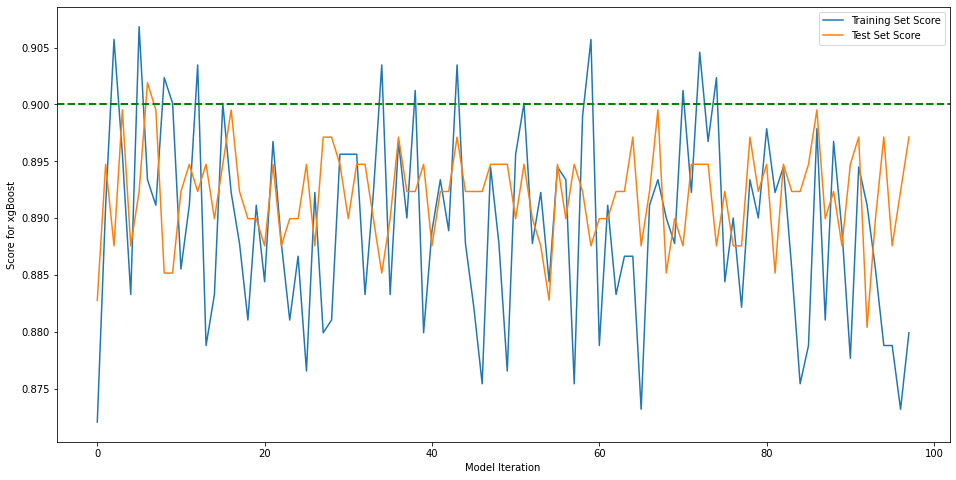

In [115]:
if bool(train_high_accur):
  plot_train_test(train_high_accur, test_high_accur)

Training set score for xgBoost: 0.906846
Testing set score for xgBoost: 0.892344



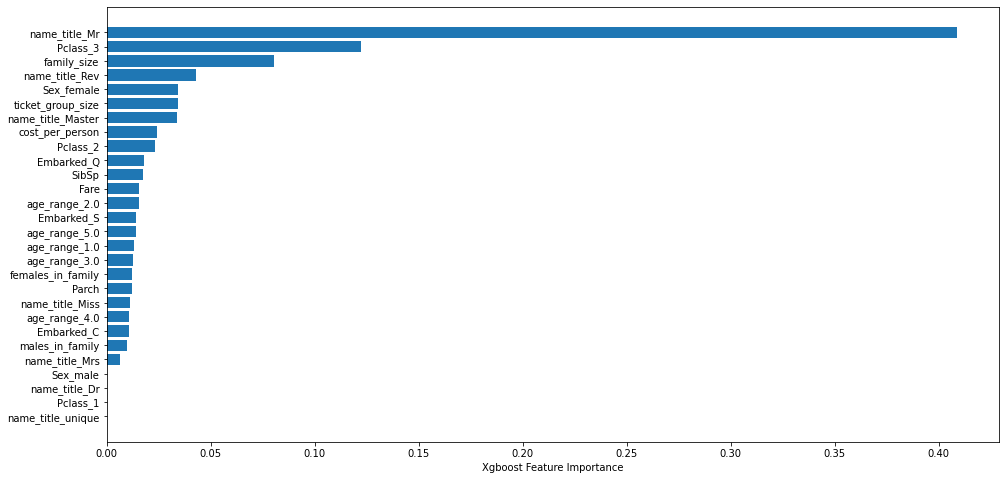

In [116]:
best_hyp()

y_test, y_test_pred = model_tuned()

In [117]:
print(classification_report(y_test.to_numpy(), y_test_pred))

              precision    recall  f1-score   support

           0       0.92      0.91      0.91       266
           1       0.84      0.87      0.85       152

    accuracy                           0.89       418
   macro avg       0.88      0.89      0.88       418
weighted avg       0.89      0.89      0.89       418



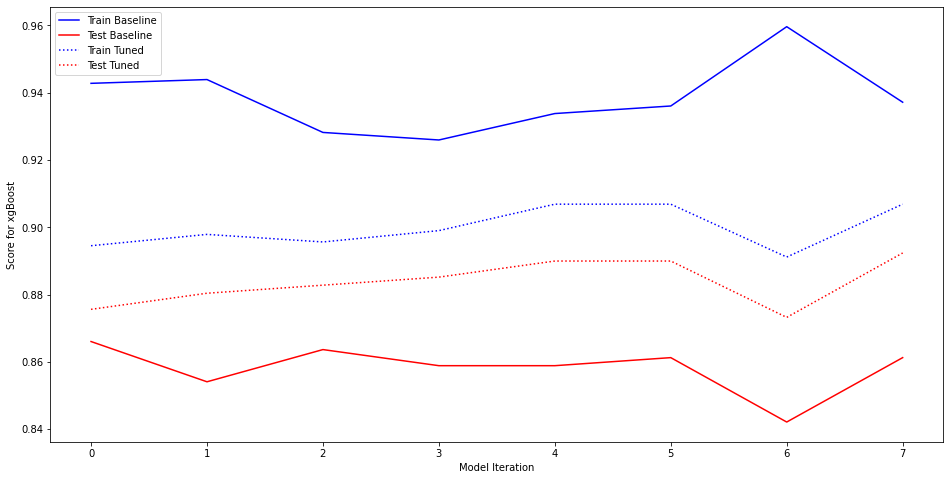

In [118]:
model_performance_trend()

## Create new categories for mother/fathers.

In [119]:
df_master['parent_female'] = 0
df_master['parent_male'] = 0

In [120]:
for p_class, gender in zip(list(set(df_master.Pclass)) * 2, ['male', 'female'] * len(set(df_master.Pclass))):
    
    filter_by_1 = (df_master.Pclass == p_class) & (df_master.family_size > 2)
       
    for family in list(set(df_master[filter_by_1].last_name)):
        filter_by_2 = filter_by_1 & (df_master.last_name == family)
#         print(family)
        
        if len(df_master[filter_by_2 & (df_master.Sex == gender)]) > 0:
        
            index = df_master[filter_by_2 & (df_master.Sex == gender)]['Age'].idxmax()
            
            df_master.at[index, 'parent_' + gender] = 1
            

In [121]:
df_master.columns

Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Embarked', 'name_title', 'first_name', 'last_name', 'age_range',
       'ticket_group_size', 'cost_per_person', 'family_size', 'family_cat',
       'males_in_family', 'females_in_family', 'parent_female', 'parent_male'],
      dtype='object')

Training set score for xgBoost: 0.938272
Testing set score for xgBoost: 0.866029



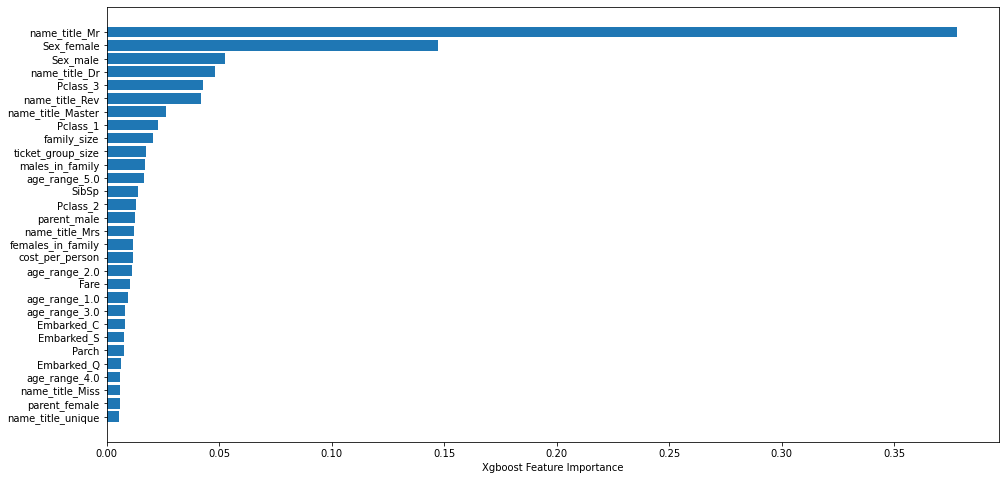

In [122]:
columns_drop = ['Name', 'Ticket','first_name','last_name', 'family_cat', 'Age']
columns_one_hot = ['Pclass','Sex','Embarked','name_title', 'age_range']


X_train, X_test, df_final = test_train_split(df_master, columns_drop, columns_one_hot)

y_test, y_test_pred = model_baseline()

In [123]:
print(classification_report(y_test.to_numpy(), y_test_pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       266
           1       0.82      0.82      0.82       152

    accuracy                           0.87       418
   macro avg       0.86      0.86      0.86       418
weighted avg       0.87      0.87      0.87       418



In [124]:
clear_parameters()

trials = Trials()

best_hyperparams = fmin(fn = bayesian_opt,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = max_evals,
                        trials = trials)

100%|██████████| 200/200 [00:31<00:00,  6.43it/s, best loss: 5.907023450879567e-05]


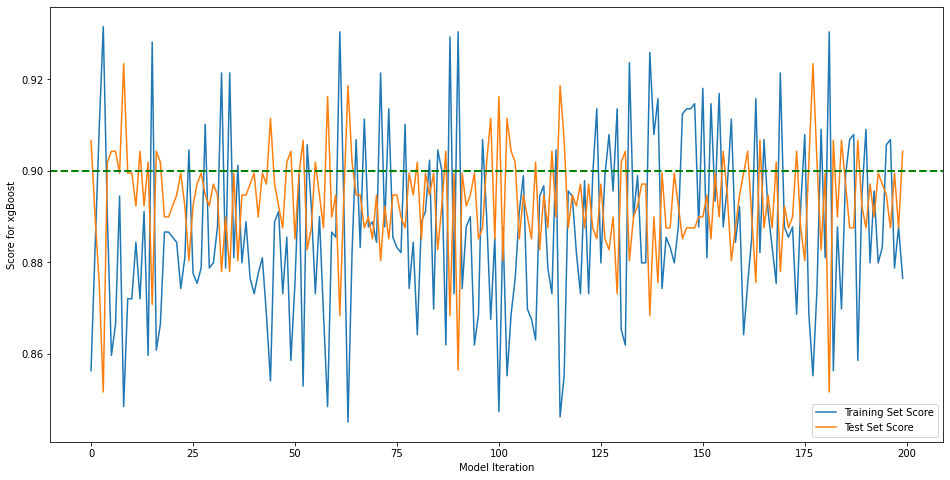

In [125]:
plot_train_test(train_score, test_score)

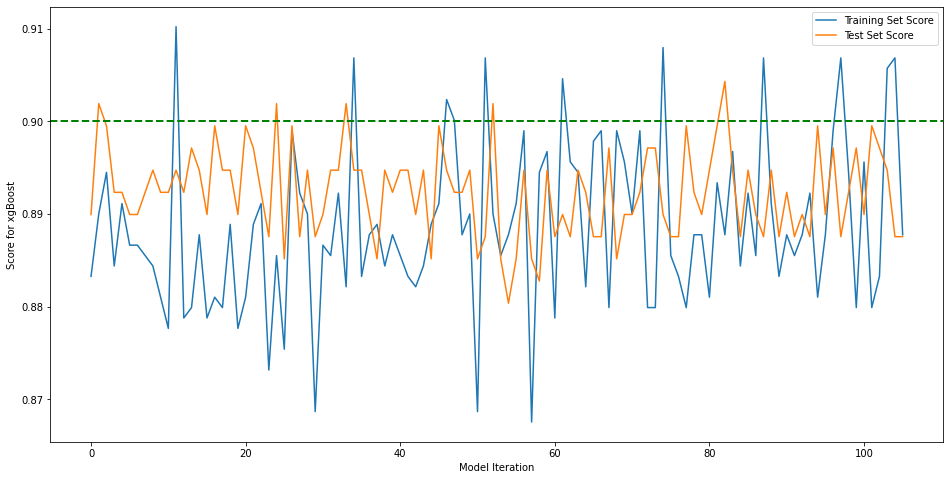

In [126]:
if bool(train_high_accur):
  plot_train_test(train_high_accur, test_high_accur)

Training set score for xgBoost: 0.910213
Testing set score for xgBoost: 0.894737



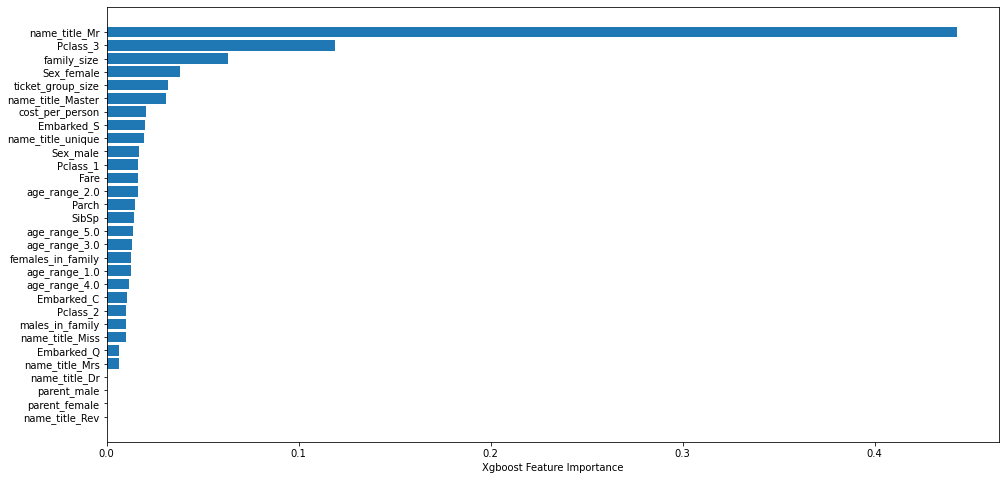

In [127]:
best_hyp()

y_test, y_test_pred = model_tuned()

In [128]:
print(classification_report(y_test.to_numpy(), y_test_pred))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       266
           1       0.85      0.87      0.86       152

    accuracy                           0.89       418
   macro avg       0.88      0.89      0.89       418
weighted avg       0.90      0.89      0.90       418



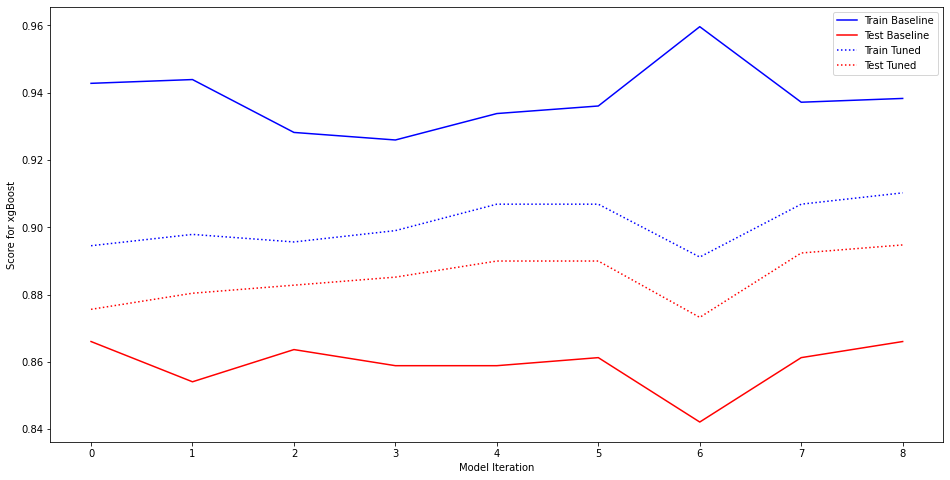

In [129]:
model_performance_trend()